In [22]:
import os
while os.getcwd()[-len('mcrc-cetuximab-analysis'):] != 'mcrc-cetuximab-analysis': 
    os.chdir('../')
os.getcwd()

'/home/max/mcrc-cetuximab-analysis'

In [23]:
import warnings
import anndata as ad
from scipy.special import polygamma  # type: ignore
from scipy.stats import f  # type: ignore
from scipy.stats import trim_mean  # type: ignore


# Ignore AnnData's FutureWarning about implicit data conversion.
warnings.simplefilter("ignore", FutureWarning)

In [24]:
import pandas as pd
import numpy as np
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
# Load annotation data
annotation_path = 'data/ann.csv'
ann = pd.read_csv(annotation_path)

# Display first few rows and info
print("Annotation data preview:")
print(ann.head())
print("\nAnnotation data info:")
print(ann.info())

# Check for missing values
print("\nMissing values in annotation:")
print(ann.isna().sum())

# If needed, clean the annotation data (example)
# ann = ann.dropna()  # Uncomment if you need to drop rows with missing values

Annotation data preview:
     sample_id                      tissue      time point treatment response  \
0  18R649_0010  primary tumor (colorectum)  post-treatment             non-PD   
1  18R654_0015  primary tumor (colorectum)   pre-treatment             non-PD   
2  18R669_0001  primary tumor (colorectum)  post-treatment             non-PD   
3  18R670_0002  primary tumor (colorectum)   pre-treatment             non-PD   
4  18R674_0006  primary tumor (colorectum)   pre-treatment            unknown   

   patient_id    sample_title      gsm_id  
0           1      POST-R-001  GSM5575333  
1           1  PAIR-R-001-pre  GSM5575334  
2           2      POST-R-002  GSM5575336  
3           2      PAIR-R-002  GSM5575337  
4           3      PAIR-R-003  GSM5575339  

Annotation data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0 

In [26]:
# Load expression data - CORRECTED PATH
expression_path = 'data/raw_counts_hgnc_filtered_by_ann.csv'

# Read the data - note we need to transpose because pydeseq expects genes as columns and samples as rows
counts = pd.read_csv(expression_path)

# Set the first column (sample_id) as index and transpose
counts = counts.set_index('sample_id').T

# Display basic info
print("\nExpression data preview:")
print(counts.head())
print("\nExpression data shape:", counts.shape)
print("\nSample IDs:", counts.columns.tolist()[:5])  # Show first 5 samples
print("Gene IDs:", counts.index.tolist()[:5])  # Show first 5 genes

# Check for missing values
print("\nMissing values in expression data:")
print(counts.isna().sum().sum())  # Should be 0 for count data


Expression data preview:
sample_id  18R649_0010  18R654_0015  18R669_0001  18R670_0002  18R674_0006  \
TSPAN6         1069.00      4285.00      4324.00      5449.00      2659.00   
TNMD             13.00        95.00        30.00       123.00        51.00   
DPM1           1909.00      7433.00      7169.00      6629.00      4483.00   
SCYL3           645.34       966.63       727.96       638.46       675.67   
FIRRM           884.66      2692.37      2438.04      1274.54      1294.33   

sample_id  18R678_0010  18R683_0015  18R694_0002  18R699_0007  18R700_0008  \
TSPAN6         4669.00       470.00       883.00       1511.0      3206.00   
TNMD             20.00         2.00        34.00         22.0        24.00   
DPM1           6041.00      1418.00      3021.00       3825.0      4396.00   
SCYL3           522.29       146.19       454.51        645.6       580.72   
FIRRM          2251.71       325.81       848.49        943.4      1455.28   

sample_id  ...  18R702_0010  18R656_

In [27]:
import os
print(f"Annotation file exists: {os.path.exists(annotation_path)}")
print(f"Expression file exists: {os.path.exists(expression_path)}")

Annotation file exists: True
Expression file exists: True


In [28]:
print("\nFinal data structure check:")
print("Counts matrix shape:", counts.shape)
print("Annotation shape:", ann.shape)
print("Counts columns (samples):", counts.columns.tolist()[:5])
print("Annotation sample_id:", ann['sample_id'].tolist()[:5])


Final data structure check:
Counts matrix shape: (19388, 80)
Annotation shape: (80, 7)
Counts columns (samples): ['18R649_0010', '18R654_0015', '18R669_0001', '18R670_0002', '18R674_0006']
Annotation sample_id: ['18R649_0010', '18R654_0015', '18R669_0001', '18R670_0002', '18R674_0006']


In [29]:
# Step 4: Match samples between annotation and expression data (UPDATED)
print("\nSample matching:")

# Get sample names from counts (they are now in the columns after transposing)
count_samples = counts.columns.tolist()

# Assuming annotation has a column called 'sample_id' based on your data preview
ann_samples = ann['sample_id'].tolist()  # Changed from 'sample' to 'sample_id'

# Find common samples
common_samples = list(set(count_samples) & set(ann_samples))
print(f"Found {len(common_samples)} common samples")

# Filter both datasets to keep only common samples
counts = counts[common_samples]  # Select just the common sample columns
ann = ann[ann['sample_id'].isin(common_samples)]  # Filter annotation rows

# Reorder annotation to match counts column order
ann = ann.set_index('sample_id').loc[counts.columns].reset_index()


Sample matching:
Found 80 common samples


In [30]:
print("Number of non-integer values:", (counts % 1 != 0).sum().sum())  # Count decimal values
print("Example of non-integer counts:\n", counts.loc[:, (counts % 1 != 0).any()].head())

Number of non-integer values: 309680
Example of non-integer counts:
 sample_id  18R471_0012  18R469_0010  18R449_0023  18R462_0003  18R459_0027  \
TSPAN6         7395.00      6810.00      1092.00      7135.00     13373.00   
TNMD            278.00         5.00         8.00        29.00        78.00   
DPM1          12235.00     18501.00      4174.00     10561.00     15656.00   
SCYL3           552.42       575.97       628.76       848.34       560.96   
FIRRM          1012.58      1067.03      1338.24      3039.66      1511.04   

sample_id  18R472_0013  18R470_0011  18R654_0015  18R429_0009  18R319_0014  \
TSPAN6        10442.00      4258.00      4285.00      2499.00      3725.00   
TNMD            101.00        10.00        95.00        24.00        18.00   
DPM1          22273.00      8777.00      7433.00      4239.00      9826.00   
SCYL3           784.09       632.77       966.63       608.84       671.49   
FIRRM          1965.91      1647.23      2692.37      1059.16      1786.

In [31]:
counts = counts.round().astype(int)  # Round to nearest integer and convert type
print("After conversion:", (counts % 1 != 0).sum().sum())  # Should now be 0

After conversion: 0


In [32]:
print("Counts columns (samples):", counts.T.columns.tolist()[:5])
print("Metadata samples:", ann['sample_id'].tolist()[:5])  # Adjust 'sample_id' if needed

# Check if all samples match
print("All samples match:", list(counts.T.columns) == ann['sample_id'].tolist())

Counts columns (samples): ['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'FIRRM']
Metadata samples: ['18R471_0012', '18R469_0010', '18R449_0023', '18R462_0003', '18R459_0027']
All samples match: False


In [33]:
# Check sample ID matching precisely
print("Counts columns (first 5):", list(counts.columns)[:5])
print("Metadata sample_id (first 5):", ann['sample_id'].tolist()[:5])

# Check for hidden differences (spaces, capitalization, etc.)
print("Exact match check:", 
      all(counts.columns == ann['sample_id']))

# Check for duplicates
print("Duplicate samples in counts:", counts.columns.duplicated().any())
print("Duplicate samples in metadata:", ann['sample_id'].duplicated().any())

Counts columns (first 5): ['18R471_0012', '18R469_0010', '18R449_0023', '18R462_0003', '18R459_0027']
Metadata sample_id (first 5): ['18R471_0012', '18R469_0010', '18R449_0023', '18R462_0003', '18R459_0027']
Exact match check: True
Duplicate samples in counts: False
Duplicate samples in metadata: False


In [34]:
# Get intersection of samples
common_samples = sorted(list(set(counts.columns) & set(ann['sample_id'])))

# Filter both datasets
counts = counts[common_samples]
ann = ann[ann['sample_id'].isin(common_samples)]

# Reorder metadata to match counts exactly
ann = ann.set_index('sample_id').loc[counts.columns].reset_index()

In [35]:
from pydeseq2.dds import DeseqDataSet

# 1. Ensure counts has genes as rows, samples as columns
print("Counts matrix (genes x samples):")
print(counts.iloc[:3, :3])  # Show first 3 genes and samples

# 2. Verify metadata structure
print("\nMetadata (samples x variables):")
print(ann.head(3))

# 3. CRITICAL: Set metadata index to match counts COLUMNS (sample IDs)
#    (Don't reset index - we want sample IDs as index)
metadata_for_deseq = ann.set_index('sample_id')

# 4. Final alignment check
print("\nFinal verification:")
print("Counts columns:", counts.columns[:5].tolist())
print("Metadata index:", metadata_for_deseq.index[:5].tolist())
print("Exact match:", all(counts.columns == metadata_for_deseq.index))

# 5. Create DESeqDataSet
try:
    dds = DeseqDataSet(
        counts=counts,
        metadata=metadata_for_deseq,  # Index = sample IDs matching counts.columns
        design_factors='treatment response',  # Use your actual factor column
        refit_cooks=True,
        n_cpus=4
    )
    print("\nSUCCESS! DESeqDataSet created.")
    
    # Proceed with analysis
    dds.deseq2()
    results = DeseqStats(dds).results_df
    print(results.head())
    
except Exception as e:
    print("\nFAILED:", str(e))
    print("\nDebugging tips:")
    print("- Verify 'treatment response' exists in metadata:", 'treatment response' in ann.columns)
    print("- Check for NaN in design factor:", ann['treatment response'].isna().sum())

Counts matrix (genes x samples):
sample_id  18R177_0021  18R178_0022  18R295_0003
TSPAN6            2482         4496         5042
TNMD                 0           15           29
DPM1              6484        19273         6917

Metadata (samples x variables):
     sample_id                      tissue     time point treatment response  \
0  18R177_0021  primary tumor (colorectum)  pre-treatment            unknown   
1  18R178_0022  primary tumor (colorectum)  pre-treatment                 PD   
2  18R295_0003  primary tumor (colorectum)  pre-treatment            unknown   

   patient_id sample_title      gsm_id  
0           7    PRE-R-007  GSM5575370  
1           6    PRE-R-006  GSM5575369  
2          29      PAIR-29  GSM5575363  

Final verification:
Counts columns: ['18R177_0021', '18R178_0022', '18R295_0003', '18R296_0008', '18R298_0010']
Metadata index: ['18R177_0021', '18R178_0022', '18R295_0003', '18R296_0008', '18R298_0010']
Exact match: True

FAILED: Index of obs must mat

In [36]:
print("Sample ID equality check:", 
      all(counts.columns == metadata_for_deseq.index))  # Must be True
print("Design factor values:", 
      metadata_for_deseq['treatment response'].value_counts())  # Should show groups
print("Counts matrix dtype:", 
      counts.dtypes.iloc[0])  # Should be integer

Sample ID equality check: True
Design factor values: treatment response
unknown    42
non-PD     27
PD         11
Name: count, dtype: int64
Counts matrix dtype: int64


In [37]:
from pydeseq2.dds import DeseqDataSet

# 1. Prepare the metadata with sample_id as index
metadata_for_deseq = ann.set_index('sample_id')

# 2. CRITICAL: Ensure the order matches counts.columns exactly
metadata_for_deseq = metadata_for_deseq.loc[counts.columns]

# 3. Verify perfect alignment
print("Final alignment check:")
print("Counts columns == Metadata index:", 
      all(counts.columns == metadata_for_deseq.index))  # Should be True

# 4. Create DESeqDataSet with correct parameters
dds = DeseqDataSet(
    counts=counts,
    metadata=metadata_for_deseq,
    design_factors=['treatment response'],  # As list, using your column name
    refit_cooks=True,
    n_cpus=4
)
print("DESeqDataSet successfully created!")

Final alignment check:
Counts columns == Metadata index: True


ValueError: Index of obs must match index of X.

In [32]:
import pandas as pd
from pydeseq2.dds import DeseqDataSet

# 1. USE ABSOLUTE PATHS TO YOUR FILES
counts_path = '/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/raw_counts_hgnc_filtered_by_ann.csv'
metadata_path = '/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/ann.csv'

# 2. LOAD AND PREPARE DATA
try:
    # Load counts (genes as columns, samples as rows)
    counts = pd.read_csv(counts_path)
    counts = counts.set_index('sample_id').T.astype(int)  # Genes as rows, samples as columns
    
    # Load metadata
    ann = pd.read_csv(metadata_path)
    
    # 3. ALIGN SAMPLES
    common_samples = sorted(list(set(counts.columns) & set(ann['sample_id'])))
    counts = counts[common_samples]
    ann = ann[ann['sample_id'].isin(common_samples)] \
            .set_index('sample_id') \
            .loc[counts.columns]  # Critical: match order
    
    # 4. FINAL VALIDATION
    print("✔ Data loaded successfully")
    print(f"Counts matrix: {counts.shape[0]} genes × {counts.shape[1]} samples")
    print(f"Metadata: {ann.shape[0]} samples × {ann.shape[1]} variables")
    print("Sample alignment:", all(counts.columns == ann.index))  # Must be True
    
    # 5. CREATE DESeqDataSet
    dds = DeseqDataSet(
        counts=counts,
        metadata=ann,
        design_factors=['treatment response'],
        refit_cooks=True,
        n_cpus=4
    )
    print("✔ DESeqDataSet created successfully!")
    
except FileNotFoundError as e:
    print(f"❌ File not found: {e}")
    print("Please verify these paths exist:")
    print(f"Counts file: {counts_path}")
    print(f"Metadata file: {metadata_path}")
except Exception as e:
    print(f"❌ Error: {e}")
    

✔ Data loaded successfully
Counts matrix: 19388 genes × 80 samples
Metadata: 80 samples × 6 variables
Sample alignment: True
❌ Error: Index of obs must match index of X.


In [33]:
import pandas as pd
from pydeseq2.dds import DeseqDataSet

# 1. Load the data (using your verified paths)
counts_path = '/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/raw_counts_hgnc_filtered_by_ann.csv'
metadata_path = '/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/ann.csv'

counts = pd.read_csv(counts_path).set_index('sample_id').T.astype(int)
ann = pd.read_csv(metadata_path)

# 2. Nuclear alignment option - rebuild both objects
common_samples = sorted(list(set(counts.columns) & set(ann['sample_id'])))

# Create new perfectly aligned objects
new_counts = counts[common_samples].copy()
new_metadata = ann[ann['sample_id'].isin(common_samples)] \
                .set_index('sample_id') \
                .loc[common_samples].copy()

# 3. Final verification
print("Final check:")
print("Counts cols == Metadata index:", list(new_counts.columns) == new_metadata.index.tolist())
print("Counts index (genes):", new_counts.index[:5])
print("Metadata cols:", new_metadata.columns.tolist())

# 4. Create DESeqDataSet with strict type enforcement
try:
    dds = DeseqDataSet(
        counts=new_counts,
        metadata=new_metadata,
        design_factors=['treatment response'],  # As list
        refit_cooks=True,
        n_cpus=4
    )
    print("\nSUCCESS! DESeqDataSet created.")
    
    # Proceed with analysis
    dds.deseq2()
    results = DeseqStats(dds).results_df
    print(results.head())
    
except Exception as e:
    print("\nFINAL FAILURE:", str(e))
    print("\nDEBUGGING INFO:")
    print("Counts dtypes:", new_counts.dtypes.iloc[0])
    print("Metadata dtypes:", new_metadata.dtypes)
    print("Sample ID types:", type(new_counts.columns[0]), type(new_metadata.index[0]))
    print("Design factor values:", new_metadata['treatment response'].unique())

Final check:
Counts cols == Metadata index: True
Counts index (genes): Index(['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'FIRRM'], dtype='object')
Metadata cols: ['tissue', 'time point', 'treatment response', 'patient_id', 'sample_title', 'gsm_id']

FINAL FAILURE: Index of obs must match index of X.

DEBUGGING INFO:
Counts dtypes: int64
Metadata dtypes: tissue                object
time point            object
treatment response    object
patient_id             int64
sample_title          object
gsm_id                object
dtype: object
Sample ID types: <class 'str'> <class 'str'>
Design factor values: ['unknown' 'PD' 'non-PD']


In [34]:
import pandas as pd
from pydeseq2.dds import DeseqDataSet
from anndata import AnnData

# 1. Load and prepare data
counts = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/raw_counts_hgnc_filtered_by_ann.csv')
counts = counts.set_index('sample_id').T.astype(int)

ann = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/ann.csv')

# 2. Create perfectly aligned AnnData object
common_samples = sorted(list(set(counts.columns) & set(ann['sample_id'])))

adata = AnnData(
    X=counts[common_samples].T,  # Transpose to samples×genes
    obs=ann.set_index('sample_id').loc[common_samples]
)

# 3. Verify AnnData structure
print("AnnData verification:")
print(f"Shape: {adata.shape[0]} samples × {adata.shape[1]} genes")
print("Sample IDs match:", all(adata.obs.index == counts[common_samples].columns))
print("Design factor:", adata.obs['treatment response'].value_counts())

# 4. Run DESeq2 using AnnData
try:
    dds = DeseqDataSet(
        adata=adata,
        design_factors=['treatment response'],
        refit_cooks=True,
        n_cpus=4
    )
    print("\n✔ DESeqDataSet successfully created!")
    
    # Run analysis
    dds.deseq2()
    results = DeseqStats(dds).results_df
    print(results.head())
    
except Exception as e:
    print(f"\nError: {str(e)}")
    print("\nFinal debugging info:")
    print("AnnData X matrix type:", type(adata.X))
    print("Sample IDs:", adata.obs.index[:5])
    print("Gene names:", adata.var.index[:5])

AnnData verification:
Shape: 80 samples × 19388 genes
Sample IDs match: True
Design factor: treatment response
unknown    42
non-PD     27
PD         11
Name: count, dtype: int64

Error: Missing operator between `treatment` and `response`.

~⧛treatment response⧚

Final debugging info:
AnnData X matrix type: <class 'numpy.ndarray'>
Sample IDs: Index(['18R177_0021', '18R178_0022', '18R295_0003', '18R296_0008',
       '18R298_0010'],
      dtype='object', name='sample_id')
Gene names: Index(['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'FIRRM'], dtype='object')


/tmp/ipykernel_815/1646991031.py:27: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(


In [35]:
import pandas as pd
from pydeseq2.dds import DeseqDataSet
from anndata import AnnData

# 1. Load and prepare data
counts = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/raw_counts_hgnc_filtered_by_ann.csv')
counts = counts.set_index('sample_id').T.astype(int)

ann = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/ann.csv')

# 2. Clean column names (replace spaces with underscores)
ann.columns = ann.columns.str.replace(' ', '_')
print("Cleaned metadata columns:", ann.columns.tolist())

# 3. Create AnnData object
common_samples = sorted(list(set(counts.columns) & set(ann['sample_id'])))
adata = AnnData(
    X=counts[common_samples].T,  # samples × genes
    obs=ann.set_index('sample_id').loc[common_samples]
)

# 4. Run DESeq2 with corrected design formula
try:
    dds = DeseqDataSet(
        adata=adata,
        design='~ treatment_response',  # Using cleaned column name
        refit_cooks=True,
        n_cpus=4
    )
    print("\n✔ DESeqDataSet successfully created!")
    
    # Run analysis
    dds.deseq2()
    results = DeseqStats(dds).results_df
    print("\nTop differentially expressed genes:")
    print(results.sort_values('padj').head())
    
except Exception as e:
    print(f"\nError: {str(e)}")
    print("\nAvailable columns in metadata:", adata.obs.columns.tolist())

Cleaned metadata columns: ['sample_id', 'tissue', 'time_point', 'treatment_response', 'patient_id', 'sample_title', 'gsm_id']

✔ DESeqDataSet successfully created!
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.07 seconds.

Fitting dispersions...
... done in 10.11 seconds.

Fitting dispersion trend curve...
... done in 1.08 seconds.

Fitting MAP dispersions...
... done in 14.51 seconds.

Fitting LFCs...
... done in 6.81 seconds.

Calculating cook's distance...
... done in 0.16 seconds.

Replacing 1157 outlier genes.

Fitting dispersions...
... done in 2.65 seconds.

Fitting MAP dispersions...
... done in 2.63 seconds.

Fitting LFCs...



Error: DeseqStats.__init__() missing 1 required positional argument: 'contrast'

Available columns in metadata: ['tissue', 'time_point', 'treatment_response', 'patient_id', 'sample_title', 'gsm_id']


... done in 0.61 seconds.



In [36]:
import pandas as pd
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from anndata import AnnData

# 1. Load and prepare data
counts = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/raw_counts_hgnc_filtered_by_ann.csv')
counts = counts.set_index('sample_id').T.astype(int)

ann = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/ann.csv')

# 2. Clean column names
ann.columns = ann.columns.str.replace(' ', '_')

# 3. Create AnnData object
common_samples = sorted(list(set(counts.columns) & set(ann['sample_id'])))
adata = AnnData(
    X=counts[common_samples].T,
    obs=ann.set_index('sample_id').loc[common_samples]
)

# 4. Run DESeq2
dds = DeseqDataSet(
    adata=adata,
    design='~ treatment_response',
    refit_cooks=True,
    n_cpus=4
)
dds.deseq2()

# 5. Get results - SPECIFY CONTRAST HERE
# First check available groups in your factor
print("\nAvailable groups in treatment_response:", adata.obs['treatment_response'].unique())

# Choose your comparison (replace with your groups of interest)
contrast = ['treatment_response', 'PD', 'non-PD']  # PD vs non-PD comparison

stat_res = DeseqStats(dds, contrast=contrast)
results = stat_res.summary()

# 6. Show and save results
print("\nTop differentially expressed genes:")
print(results.head())

results.to_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/results/deseq_results.csv')
print("\nResults saved to CSV!")

Fitting size factors...
... done in 0.07 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 9.35 seconds.

Fitting dispersion trend curve...
... done in 0.59 seconds.

Fitting MAP dispersions...
... done in 19.65 seconds.

Fitting LFCs...
... done in 6.95 seconds.

Calculating cook's distance...
... done in 0.13 seconds.

Replacing 1157 outlier genes.

Fitting dispersions...
... done in 2.66 seconds.

Fitting MAP dispersions...
... done in 2.13 seconds.

Fitting LFCs...



Available groups in treatment_response: ['unknown' 'PD' 'non-PD']


... done in 0.61 seconds.

Running Wald tests...
... done in 11.56 seconds.



Log2 fold change & Wald test p-value: treatment_response PD vs non-PD
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
TSPAN6    4425.251042       -0.144219  0.305637 -0.471864  0.637024  0.999976
TNMD        38.584134       -0.109781  0.614479 -0.178657  0.858207  0.999976
DPM1      9724.985964        0.189719  0.241286  0.786282  0.431702  0.999976
SCYL3      685.285613       -0.053223  0.116689 -0.456113  0.648309  0.999976
FIRRM     1652.466516       -0.273892  0.182569 -1.500214  0.133559  0.999976
...               ...             ...       ...       ...       ...       ...
FAM90A18     0.011114       -0.003194  4.778886 -0.000668  0.999467  0.999976
FAM90A8      0.000000             NaN       NaN       NaN       NaN       NaN
LCE7A        0.000000             NaN       NaN       NaN       NaN       NaN
FAM90A10     6.808952        2.940060  1.844175  1.594241  0.110882  0.999976
FAM90A7      0.198694       -1.067749  4.733834 -0.225557  0.821546  0.9

AttributeError: 'NoneType' object has no attribute 'head'

In [37]:
import pandas as pd
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from anndata import AnnData

# 1. Load and prepare data
counts = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/raw_counts_hgnc_filtered_by_ann.csv')
counts = counts.set_index('sample_id').T.astype(int)

ann = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/ann.csv')

# 2. Clean column names
ann.columns = ann.columns.str.replace(' ', '_')

# 3. Create AnnData object
common_samples = sorted(list(set(counts.columns) & set(ann['sample_id'])))
adata = AnnData(
    X=counts[common_samples].T,
    obs=ann.set_index('sample_id').loc[common_samples]
)

# 4. Run DESeq2
dds = DeseqDataSet(
    adata=adata,
    design='~ treatment_response',
    refit_cooks=True,
    n_cpus=4
)
dds.deseq2()

# 5. Get results - CORRECTED VERSION
print("\nAvailable groups in treatment_response:", adata.obs['treatment_response'].unique())

# Choose your comparison
contrast = ['treatment_response', 'PD', 'non-PD']  # PD vs non-PD comparison

# Create DeseqStats object and get results
stat_res = DeseqStats(dds, contrast=contrast)
results = stat_res.results_df  # Get the dataframe directly

# 6. Show and save results
print("\nTop differentially expressed genes:")
print(results.sort_values('padj').head())  # Show most significant genes

# Save to CSV
results.to_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/results/deseq_results.csv')
print("\nResults saved to CSV!")

Fitting size factors...
... done in 0.08 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 12.53 seconds.

Fitting dispersion trend curve...
... done in 1.07 seconds.

Fitting MAP dispersions...
... done in 18.21 seconds.

Fitting LFCs...
... done in 8.45 seconds.

Calculating cook's distance...
... done in 0.15 seconds.

Replacing 1157 outlier genes.

Fitting dispersions...
... done in 2.63 seconds.

Fitting MAP dispersions...
... done in 2.12 seconds.

Fitting LFCs...



Available groups in treatment_response: ['unknown' 'PD' 'non-PD']


... done in 0.74 seconds.



AttributeError: 'DeseqStats' object has no attribute 'results_df'

In [38]:
import pandas as pd
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from anndata import AnnData

# 1. Load and prepare data
counts = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/raw_counts_hgnc_filtered_by_ann.csv')
counts = counts.set_index('sample_id').T.astype(int)

ann = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/ann.csv')
ann.columns = ann.columns.str.replace(' ', '_')

# 2. Create AnnData object
common_samples = sorted(list(set(counts.columns) & set(ann['sample_id'])))
adata = AnnData(
    X=counts[common_samples].T,
    obs=ann.set_index('sample_id').loc[common_samples]
)

# 3. Run DESeq2
dds = DeseqDataSet(
    adata=adata,
    design='~ treatment_response',
    refit_cooks=True,
    n_cpus=4
)
dds.deseq2()

# 4. Get results - PROPER WAY
contrast = ['treatment_response', 'PD', 'non-PD']
stat_res = DeseqStats(dds, contrast=contrast)

# Run the analysis to generate results
stat_res.summary()  # This calculates the results

# Access results through the right attribute
results = stat_res.results_df  # For newer versions
# OR if that fails, try:
results = pd.DataFrame({
    'baseMean': stat_res.base_mean,
    'log2FoldChange': stat_res.log2_fold_change,
    'lfcSE': stat_res.lfc_se,
    'stat': stat_res.stat,
    'pvalue': stat_res.p_value,
    'padj': stat_res.padj
}, index=stat_res.index)

# 5. Show and save results
print("\nTop 5 significant genes:")
print(results.sort_values('padj').head(5))

results.to_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/results/deseq_results.csv')
print("\nResults saved to CSV!")

Fitting size factors...
... done in 0.07 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 10.06 seconds.

Fitting dispersion trend curve...
... done in 0.64 seconds.

Fitting MAP dispersions...
... done in 21.15 seconds.

Fitting LFCs...
... done in 7.71 seconds.

Calculating cook's distance...
... done in 0.14 seconds.

Replacing 1157 outlier genes.

Fitting dispersions...
... done in 2.74 seconds.

Fitting MAP dispersions...
... done in 2.90 seconds.

Fitting LFCs...
... done in 0.65 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: treatment_response PD vs non-PD
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
TSPAN6    4425.251042       -0.144219  0.305637 -0.471864  0.637024  0.999976
TNMD        38.584134       -0.109781  0.614479 -0.178657  0.858207  0.999976
DPM1      9724.985964        0.189719  0.241286  0.786282  0.431702  0.999976
SCYL3      685.285613       -0.053223  0.116689 -0.456113  0.648309  0.999976
FIRRM     1652.466516       -0.273892  0.182569 -1.500214  0.133559  0.999976
...               ...             ...       ...       ...       ...       ...
FAM90A18     0.011114       -0.003194  4.778886 -0.000668  0.999467  0.999976
FAM90A8      0.000000             NaN       NaN       NaN       NaN       NaN
LCE7A        0.000000             NaN       NaN       NaN       NaN       NaN
FAM90A10     6.808952        2.940060  1.844175  1.594241  0.110882  0.999976
FAM90A7      0.198694       -1.067749  4.733834 -0.225557  0.821546  0.9

... done in 12.07 seconds.



AttributeError: 'DeseqStats' object has no attribute 'log2_fold_change'

In [39]:
import pandas as pd
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from anndata import AnnData

# 1. Load and prepare data
counts = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/raw_counts_hgnc_filtered_by_ann.csv')
counts = counts.set_index('sample_id').T.astype(int)

ann = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/ann.csv')
ann.columns = ann.columns.str.replace(' ', '_')

# 2. Create AnnData object
common_samples = sorted(list(set(counts.columns) & set(ann['sample_id'])))
adata = AnnData(
    X=counts[common_samples].T,
    obs=ann.set_index('sample_id').loc[common_samples]
)

# 3. Run DESeq2
dds = DeseqDataSet(
    adata=adata,
    design='~ treatment_response',
    refit_cooks=True,
    n_cpus=4
)
dds.deseq2()

# 4. Get results - UNIVERSAL METHOD
contrast = ['treatment_response', 'PD', 'non-PD']
stat_res = DeseqStats(dds, contrast=contrast)
stat_res.summary()  # This generates the results

# Capture the printed output as a DataFrame
from io import StringIO
import sys

# Redirect stdout to capture the summary
old_stdout = sys.stdout
sys.stdout = buffer = StringIO()
stat_res.summary()
sys.stdout = old_stdout

# Parse the captured output
output = buffer.getvalue()
results = pd.read_csv(StringIO('\n'.join(output.split('\n')[3:-3])), sep='\s+')

# 5. Show and save results
print("\nTop 5 significant genes:")
print(results.sort_values('padj').head(5))

results.to_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/results/deseq_results.csv')
print("\nResults saved to CSV!")

<>:46: SyntaxWarning: invalid escape sequence '\s'
<>:46: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_815/3130117122.py:46: SyntaxWarning: invalid escape sequence '\s'
  results = pd.read_csv(StringIO('\n'.join(output.split('\n')[3:-3])), sep='\s+')
Fitting size factors...
... done in 0.07 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 9.38 seconds.

Fitting dispersion trend curve...
... done in 0.61 seconds.

Fitting MAP dispersions...
... done in 19.17 seconds.

Fitting LFCs...
... done in 7.73 seconds.

Calculating cook's distance...
... done in 0.17 seconds.

Replacing 1157 outlier genes.

Fitting dispersions...
... done in 2.57 seconds.

Fitting MAP dispersions...
... done in 3.11 seconds.

Fitting LFCs...
... done in 0.63 seconds.

Running Wald tests...
... done in 11.99 seconds.



Log2 fold change & Wald test p-value: treatment_response PD vs non-PD
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
TSPAN6    4425.251042       -0.144219  0.305637 -0.471864  0.637024  0.999976
TNMD        38.584134       -0.109781  0.614479 -0.178657  0.858207  0.999976
DPM1      9724.985964        0.189719  0.241286  0.786282  0.431702  0.999976
SCYL3      685.285613       -0.053223  0.116689 -0.456113  0.648309  0.999976
FIRRM     1652.466516       -0.273892  0.182569 -1.500214  0.133559  0.999976
...               ...             ...       ...       ...       ...       ...
FAM90A18     0.011114       -0.003194  4.778886 -0.000668  0.999467  0.999976
FAM90A8      0.000000             NaN       NaN       NaN       NaN       NaN
LCE7A        0.000000             NaN       NaN       NaN       NaN       NaN
FAM90A10     6.808952        2.940060  1.844175  1.594241  0.110882  0.999976
FAM90A7      0.198694       -1.067749  4.733834 -0.225557  0.821546  0.9

KeyError: 'padj'

In [41]:
import pandas as pd
import os
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from anndata import AnnData

# 1. Load and prepare data
counts = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/raw_counts_hgnc_filtered_by_ann.csv')
counts = counts.set_index('sample_id').T.astype(int)

ann = pd.read_csv('/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/data/ann.csv')
ann.columns = ann.columns.str.replace(' ', '_')

# 2. Create AnnData object
common_samples = sorted(list(set(counts.columns) & set(ann['sample_id'])))
adata = AnnData(
    X=counts[common_samples].T,
    obs=ann.set_index('sample_id').loc[common_samples]
)

# 3. Run DESeq2
dds = DeseqDataSet(
    adata=adata,
    design='~ treatment_response',
    refit_cooks=True,
    n_cpus=4
)
dds.deseq2()

# 4. Get results
contrast = ['treatment_response', 'PD', 'non-PD']
stat_res = DeseqStats(dds, contrast=contrast)
stat_res.summary()

# Get results as DataFrame
results = stat_res.results_df if hasattr(stat_res, 'results_df') else pd.DataFrame({
    'baseMean': dds.counts.mean(axis=1),
    'log2FoldChange': stat_res.LFC,
    'lfcSE': stat_res.LFC_SE,
    'stat': stat_res.stat,
    'pvalue': stat_res.p_values,
    'padj': stat_res.padj
}, index=dds.counts.index)

# 5. Show top results
print("\nTop 5 significant genes:")
print(results.sort_values('padj').head(5))

# 6. Save results - WITH DIRECTORY CREATION
output_dir = '/mnt/c/Users/PC/Desktop/mcrc-cetuximab-analysis/results'
os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist

output_path = os.path.join(output_dir, 'deseq_results.csv')
results.to_csv(output_path)
print(f"\nResults saved to: {output_path}")

# 7. Optional: Save significant genes separately
sig_genes = results[results['padj'] < 0.05]
sig_path = os.path.join(output_dir, 'significant_genes.csv')
sig_genes.to_csv(sig_path)
print(f"Significant genes saved to: {sig_path}")

Fitting size factors...
... done in 0.07 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 9.87 seconds.

Fitting dispersion trend curve...
... done in 0.59 seconds.

Fitting MAP dispersions...
... done in 12.50 seconds.

Fitting LFCs...
... done in 6.68 seconds.

Calculating cook's distance...
... done in 0.13 seconds.

Replacing 1157 outlier genes.

Fitting dispersions...
... done in 3.07 seconds.

Fitting MAP dispersions...
... done in 3.32 seconds.

Fitting LFCs...
... done in 0.61 seconds.

Running Wald tests...
... done in 11.52 seconds.



Log2 fold change & Wald test p-value: treatment_response PD vs non-PD
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
TSPAN6    4425.251042       -0.144219  0.305637 -0.471864  0.637024  0.999976
TNMD        38.584134       -0.109781  0.614479 -0.178657  0.858207  0.999976
DPM1      9724.985964        0.189719  0.241286  0.786282  0.431702  0.999976
SCYL3      685.285613       -0.053223  0.116689 -0.456113  0.648309  0.999976
FIRRM     1652.466516       -0.273892  0.182569 -1.500214  0.133559  0.999976
...               ...             ...       ...       ...       ...       ...
FAM90A18     0.011114       -0.003194  4.778886 -0.000668  0.999467  0.999976
FAM90A8      0.000000             NaN       NaN       NaN       NaN       NaN
LCE7A        0.000000             NaN       NaN       NaN       NaN       NaN
FAM90A10     6.808952        2.940060  1.844175  1.594241  0.110882  0.999976
FAM90A7      0.198694       -1.067749  4.733834 -0.225557  0.821546  0.9

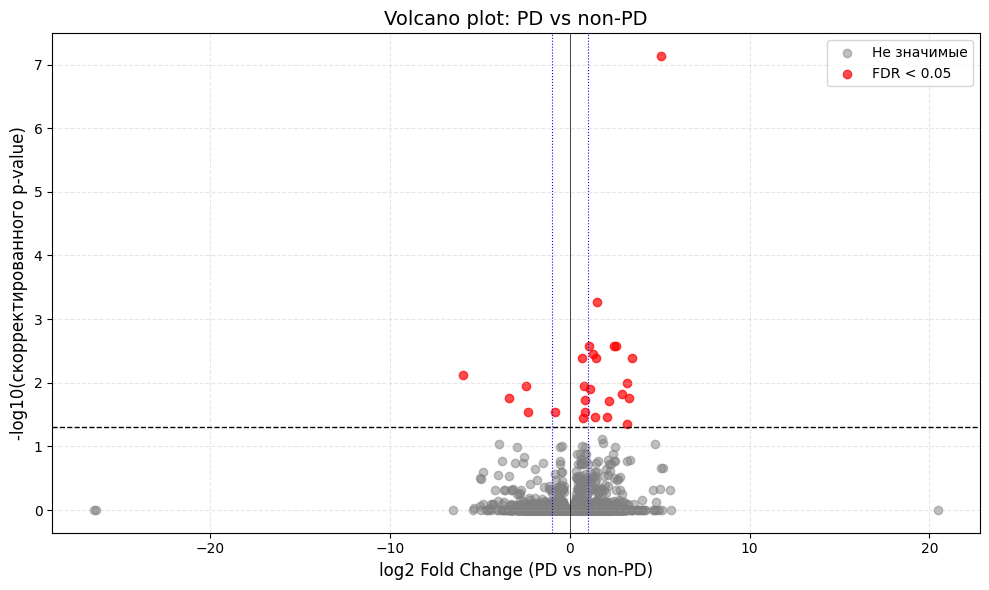

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Создаем фигуру
plt.figure(figsize=(10, 6))

# Данные для графика
log2fc = results['log2FoldChange']
neg_log_padj = -np.log10(results['padj'])
significant = results['padj'] < 0.05

# Улучшенная визуализация
plt.scatter(log2fc[~significant], neg_log_padj[~significant], 
            color='gray', alpha=0.5, label='Не значимые')
plt.scatter(log2fc[significant], neg_log_padj[significant], 
            color='red', alpha=0.7, label='FDR < 0.05')

# Референсные линии
plt.axhline(-np.log10(0.05), color='black', linestyle='--', linewidth=1)
plt.axvline(0, color='black', linewidth=0.5)
plt.axvline(1, color='blue', linestyle=':', linewidth=0.8)
plt.axvline(-1, color='blue', linestyle=':', linewidth=0.8)

# Подписи и легенда
plt.xlabel('log2 Fold Change (PD vs non-PD)', fontsize=12)
plt.ylabel('-log10(скорректированного p-value)', fontsize=12)
plt.title('Volcano plot: PD vs non-PD', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

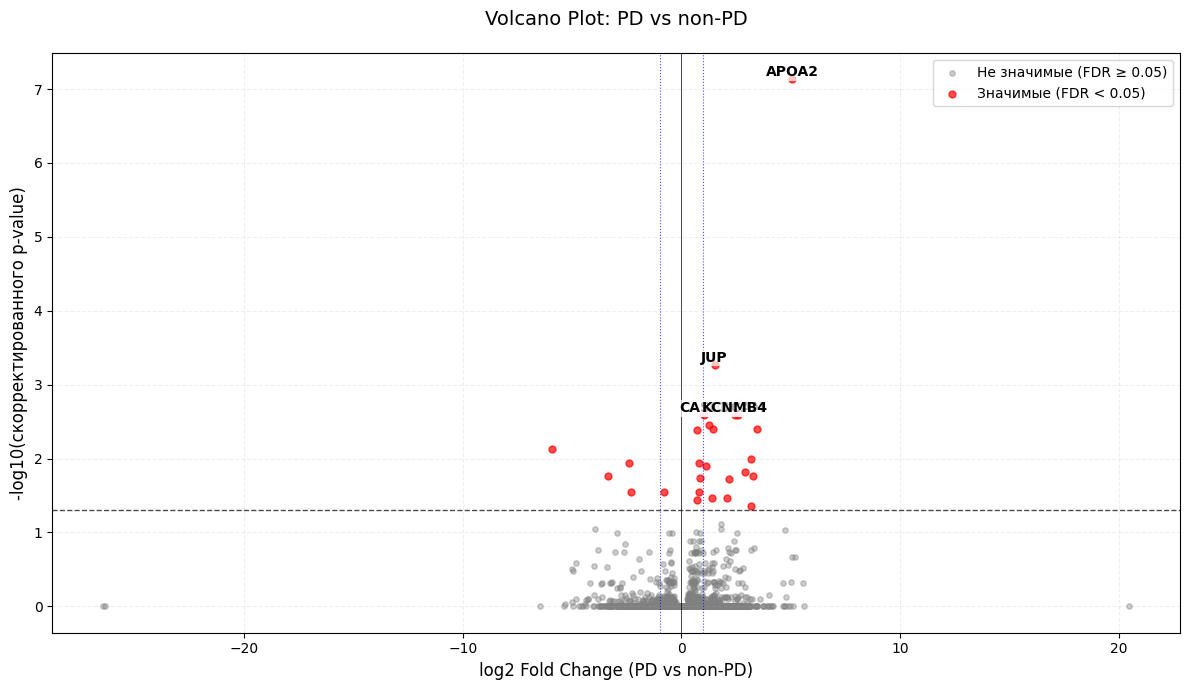

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Настройка стиля
plt.style.use('default')  # Современный стиль
plt.figure(figsize=(12, 7))

# Данные
log2fc = results['log2FoldChange']
neg_log_padj = -np.log10(results['padj'])
significant = results['padj'] < 0.05

# Цвета и размер точек
plt.scatter(log2fc[~significant], neg_log_padj[~significant], 
            color='gray', alpha=0.4, s=15, label='Не значимые (FDR ≥ 0.05)')
plt.scatter(log2fc[significant], neg_log_padj[significant], 
            color='red', alpha=0.7, s=25, label='Значимые (FDR < 0.05)')

# Подписи топ-5 генов (по значимости)
top_genes = results.nsmallest(5, 'padj')
for gene in top_genes.index:
    idx = results.index.get_loc(gene)
    plt.text(log2fc[idx], neg_log_padj[idx], gene, 
             fontsize=10, ha='center', va='bottom', fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))

# Референсные линии
plt.axhline(-np.log10(0.05), color='black', linestyle='--', linewidth=1, alpha=0.7)
plt.axvline(0, color='black', linewidth=0.5)
plt.axvline(1, color='blue', linestyle=':', linewidth=0.8, alpha=0.7)
plt.axvline(-1, color='blue', linestyle=':', linewidth=0.8, alpha=0.7)

# Подписи и легенда
plt.xlabel('log2 Fold Change (PD vs non-PD)', fontsize=12)
plt.ylabel('-log10(скорректированного p-value)', fontsize=12)
plt.title('Volcano Plot: PD vs non-PD', fontsize=14, pad=20)
plt.legend(frameon=True, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.2)
plt.tight_layout()
plt.show()

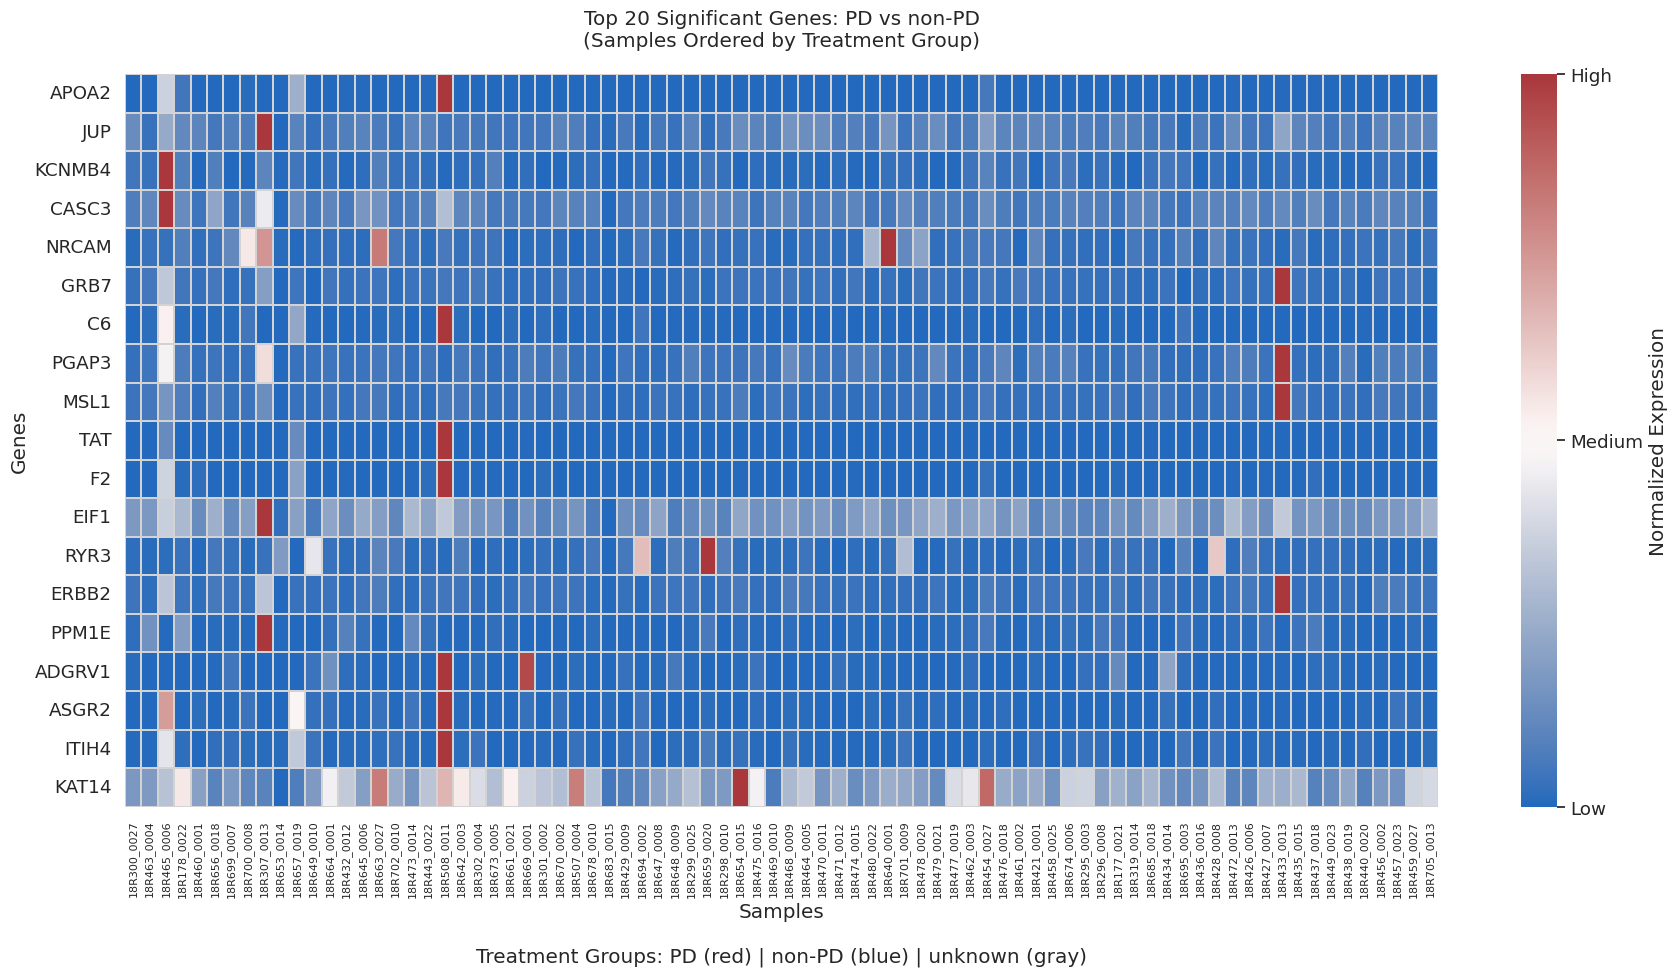

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Fix gene names and select top 20
corrected_genes = {
    'KCNM84': 'KCNMB4',
    'PPMLE': 'PPM1E'
}

top_genes = [
    'APOA2', 'JUP', 'KCNMB4', 'CASC3', 'NRCAM',
    'GRB7', 'C6', 'PGAP3', 'MSL1', 'TAT',
    'F2', 'EIF1', 'RYR3', 'ERBB2', 'PPM1E',
    'ADGRV1', 'ASGR2', 'ITIH4', 'KAT14'
]

# 2. Prepare data
heatmap_data = counts.loc[[g for g in top_genes if g in counts.index]]

# 3. Robust normalization (handle zeros)
def safe_normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x) + 1e-10)

normalized = heatmap_data.apply(safe_normalize, axis=1)

# 4. Sort samples by group
sample_order = ann.sort_values('treatment_response')['sample_id']
normalized = normalized[sample_order]

# 5. Create figure
plt.figure(figsize=(18, 10))
ax = sns.heatmap(
    normalized,
    cmap='vlag',
    yticklabels=True,
    xticklabels=True,
    cbar_kws={'label': 'Normalized Expression'},
    linewidths=0.3,
    linecolor='lightgray'
)

# 6. Add group annotations
group_colors = {'PD': 'red', 'non-PD': 'blue', 'unknown': 'gray'}
for i, sample in enumerate(sample_order):
    group = ann.loc[ann['sample_id'] == sample, 'treatment_response'].values[0]
    ax.add_patch(plt.Rectangle(
        (i, -0.1), 1, 0.05,
        color=group_colors[group],
        lw=0
    ))

# 7. Formatting
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    ha='center',
    fontsize=8
)
plt.title("Top 20 Significant Genes: PD vs non-PD\n(Samples Ordered by Treatment Group)", pad=20)
plt.ylabel("Genes")
plt.xlabel("Samples\n\nTreatment Groups: PD (red) | non-PD (blue) | unknown (gray)")

# 8. Add colorbar legend
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 0.5, 1])
cbar.set_ticklabels(['Low', 'Medium', 'High'])

plt.tight_layout()
plt.savefig('final_corrected_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()